# ATLAS OpenData Machine Learning Tutorial

This tutorial takes you through how to download ATLAS OpenData, convert the data into a format suitable for building machine learning models, and then build such a model: a "simple" deep neural network for classifying two processes as signal and background.

The signal process we consider is the production of a Higgs boson through gluon-gluon fusion, where the Higgs then decays to two W bosons which both decay leptonically.
The background process is top-antitop quark pair production, with both tops decaying through two intermediate W bosons which also decay leptonically.
Thus the final state consists of two charged leptons, some missing transverse energy, and some jets.

<img src="https://raw.githubusercontent.com/els285/Intro2NN4Physics/main/images/ATLAS-FUELED-AI-VERTICAL.png" width="300">


## Aims of this tutorial
* Pipeline for turning ATLAS OpenData for Education ROOT files into a format for machine learning
* Building and training a simple DNN model

# Part 0 - Setup

Like the other tutorials, we will make use of the excellent `atlasopenmagic` package. Note that if you're running this in SWAN, there should be an extra cell before. You may already have the required packages installed: we need `numpy`,`awkward` and `uproot` for the pre-processing, as well as `torch` and `sklearn` for the machine learning.

In [1]:
#install required packages
import sys
%pip install atlasopenmagic
from atlasopenmagic import install_from_environment
install_from_environment()

Installing packages: ['aiohttp>=3.9.5', 'atlasopenmagic>=1.2.0', 'awkward>=2.6.7', 'awkward-pandas>=2023.8.0', 'coffea~=0.7.0', 'fsspec>=2025.7.0', 'hist>=2.8.0', 'ipykernel>=6.29.5', 'jupyter>=1.0.0', 'lmfit>=1.3.2', 'matplotlib>=3.9.1', 'metakernel>=0.30.2', 'notebook<7', 'numpy>=1.26.4', 'pandas>=2.2.2', 'papermill>=2.6.0', 'pip>=24.2', 'scikit-learn>=1.5.1', 'uproot>=5.3.10', 'uproot3>=3.14.4', 'fsspec-xrootd>=0.5.1', 'jupyterlab_latex~=3.1.0', 'vector>=1.4.1']
Installation complete. You may need to restart your Python environment for changes to take effect.


In [1]:
# Check that numpy, akward, uproot, torch and sklearn are installed
import numpy as np
import awkward as ak
import uproot
import torch
import sklearn

# Part 1 - Pre-processing

## Loading data

We access the data (which is actually simulated data) through `atlasopenmagic`. Hopefully you've learned a bit about what the below cell does. We're using the newest Outreach for Education datasets at 13 TeV.

In [2]:
import atlasopenmagic as atom
atom.available_releases()
atom.set_release('2025e-13tev-beta')

Fetching metadata for release: 2025e-13tev-beta...


Available releases:
2016e-8tev           2016 Open Data for education release of 8 TeV proton-proton collisions (https://opendata.cern.ch/record/3860).
2020e-13tev          2020 Open Data for education release of 13 TeV proton-proton collisions (https://cern.ch/2r7xt).
2024r-pp             2024 Open Data for research release for proton-proton collisions (https://opendata.cern.record/80020).
2024r-hi             2024 Open Data for research release for heavy-ion collisions (https://opendata.cern.ch/record/80035).
2025e-13tev-beta     2025 Open Data for education and outreach beta release for 13 TeV proton-proton collisions (https://opendata.cern.ch/record/93910).
2025r-evgen-13tev    2025 Open Data for research release for event generation at 13 TeV (https://opendata.cern.ch/record/160000).
2025r-evgen-13p6tev  2025 Open Data for research release for event generation at 13.6 TeV (https://opendata.cern.ch/record/160000).


Fetching datasets: 100%|██████████| 374/374 [00:00<00:00, 499.02datasets/s]
✓ Successfully cached 374 datasets.
Active release: 2025e-13tev-beta. (Datasets path: REMOTE)


The cell below provides the URL for the signal and background files. We are using the `2to4lep` skim. This skim is a slice of the data which contains between 2 and 4 leptons - and we'll apply further selections later.

In [3]:
signal_file_list     = atom.get_urls('346802', skim="2to4lep", protocol='https', cache=True)
background_file_list = atom.get_urls('411234', skim="2to4lep", protocol='https', cache=True)

## Data pre-processing


The above cells are all `atlasopenmagic` functionality to get our data. We will now use the scikit-HEP software stack to:
* Load the data (it's in the form of ROOT files)
* Perform some basic selections to filter the data
* Convert directly to PyTorch tensors

We will perform the operations on the signal file, and then you can repeat these operations on the background file.

In [4]:
signal_file = uproot.open(signal_file_list[0])
signal_tree = signal_file["analysis"]

We will extract only jet, lepton and MET information. The below creates an awkward array with all these fields

In [5]:
signal_array = signal_tree.arrays(["lep_pt", "lep_eta", "lep_phi", "lep_e",
                                  "jet_pt", "jet_eta", "jet_phi", "jet_e",
                                  "met", "met_phi"])

We are now in a position to apply some selections to the data. Firstly, we will stipulate that we want at least 2 jets in each event, creating a new array with this selection applied.

In [6]:
# Creates a mask which is True for events with at least 2 jets
mask_2plus_jets = ak.num(signal_array["jet_pt"]) >= 2

# Apply the mask to select only those events
signal_filtered_array = signal_array[mask_2plus_jets]

We used the "2to4lep" skim but we want to look specifically in the channel that has exactly two charged leptons.
Here we apply a more complex selection, where we filter on lepton pT, and then require that two leptons remain after this.

(This is an example of an object-level selection followed by an event-level selection, and we have to apply the cuts in this order. Do you see why?)




In [7]:
# Construct mask for >
lep_10GEV_mask = signal_filtered_array["lep_pt"] >= 10

# Apply the mask to select only leptons with pt >= 10 GeV. We over-write the columns in the signal_filtered_array
signal_filtered_array["lep_pt"] = signal_filtered_array["lep_pt"][lep_10GEV_mask]
signal_filtered_array["lep_eta"] = signal_filtered_array["lep_eta"][lep_10GEV_mask]
signal_filtered_array["lep_phi"] = signal_filtered_array["lep_phi"][lep_10GEV_mask]
signal_filtered_array["lep_e"] = signal_filtered_array["lep_e"][lep_10GEV_mask]

In [8]:
# Build the mask to specify exactly 2 leptons
mask_exactly2leptons = ak.num(signal_filtered_array["lep_pt"]) == 2

# Apply that selection
final_signal_array = signal_filtered_array[mask_exactly2leptons]

We can see how the total number of events changes as a function of the selections we've applied

In [9]:
print("Number of events in the original signal dataset:", len(signal_array))
print("Number of events with at least 2 jets:", len(signal_filtered_array))
print("Number of events with at least 2 jets and 2 leptons with pt >= 10 GeV:", len(final_signal_array))

Number of events in the original signal dataset: 581445
Number of events with at least 2 jets: 148161
Number of events with at least 2 jets and 2 leptons with pt >= 10 GeV: 129841


# Part 2 - Moving to PyTorch

## Converting to PyTorch

`PyTorch` is a Python library for building machine learning models, everything from simple deep neural networks to advanced state-of-the-art models!

For this exercise, we will turn everything into a torch tensor.
The tensor will be two-dimensional and have the shape `number_of_events x number_of_branches`.
This is because we are going to train a deep neural network, which will require each data instance (each event) to be a 1D vector of values.

 Let's practice just by taking the kinematics of the zeroth lepton in each event, converting these into individual tensors and then stacking them together.

In [10]:
# Import the torch module
import torch

Let's look at how to convert the zeroth lepton kinematics to individual torch tensors, then combine in to one big tensor

In [11]:
# Convert the lepton kinematic variables of the zeroth lepton in each event to PyTorch tensors.
# The [:,0] indexing selects the zeroth lepton from each event.
# We also define the datatype for each array - this makes things faster

lepton0_pt_tensor  = torch.tensor(final_signal_array["lep_pt"][:,0] , dtype=torch.float32)
lepton0_eta_tensor = torch.tensor(final_signal_array["lep_eta"][:,0], dtype=torch.float32)
lepton0_phi_tensor = torch.tensor(final_signal_array["lep_phi"][:,0], dtype=torch.float32)
lepton0_e_tensor   = torch.tensor(final_signal_array["lep_e"][:,0]  , dtype=torch.float32)

In [12]:
# Stack the tensors into a single tensor
signal_tensor = torch.stack([lepton0_pt_tensor,
             lepton0_eta_tensor,
             lepton0_phi_tensor,
             lepton0_e_tensor], dim=1)

We now have an object that we can use to train machine learning tools!

I have written this in a verbose way to hopefully make it clear what is happening in the simple case where the consider only one of the leptons.

Let's extend this to converting all the data in our signal_array into torch. The following code looks a complicated but simply creates a tensor of zeros and then fills each column with the data from our signal array.


In [13]:
signal_tensor = torch.zeros(len(final_signal_array), 18)

for i,branch in enumerate(["lep_pt","lep_eta","lep_phi","lep_e"]):
    signal_tensor[:,i]    = torch.tensor(final_signal_array[branch][:,0], dtype=torch.float32)
    signal_tensor[:,i+4]  = torch.tensor(final_signal_array[branch][:,1], dtype=torch.float32)

for i,branch in enumerate(["jet_pt","jet_eta","jet_phi","jet_e"]):
    signal_tensor[:,i+8]  = torch.tensor(final_signal_array[branch][:,0], dtype=torch.float32)
    signal_tensor[:,i+12] = torch.tensor(final_signal_array[branch][:,1], dtype=torch.float32)

signal_tensor[:,16] = torch.tensor(final_signal_array["met"] , dtype=torch.float32)
signal_tensor[:,17] = torch.tensor(final_signal_array["met_phi"], dtype=torch.float32)

Now we need to do the same thing for the background dataset. Please copy the above steps to load, apply selections and build a tensor called `background_tensor`. Note that the background dataset has more events, so to speed things up you can cut this at 150k events.

If you want an easy life, just use the function below...

In [172]:
def prepare_data(file_path):

  """
  This function takes as argument the path to a ROOT file;
  Applies the selections and transformations outlined above;
  Converts the output to a PyTorch tensor and returns it.
  """

  file = uproot.open(file_path)
  tree = file["analysis"]

  array = tree.arrays(["lep_pt", "lep_eta", "lep_phi", "lep_e",
                                  "jet_pt", "jet_eta", "jet_phi", "jet_e",
                                  "met", "met_phi"])

  # Creates a mask which is True for events with at least 2 jets
  mask_2plus_jets = ak.num(array["jet_pt"]) >= 2

  # Apply the mask to select only those events
  filtered_array = array[mask_2plus_jets]

  # Construct mask for >
  lep_10GEV_mask = filtered_array["lep_pt"] >= 10

  # Apply the mask to select only leptons with pt >= 10 GeV. We over-write the columns in the signal_filtered_array
  filtered_array["lep_pt"]  = filtered_array["lep_pt"][lep_10GEV_mask]
  filtered_array["lep_eta"] = filtered_array["lep_eta"][lep_10GEV_mask]
  filtered_array["lep_phi"] = filtered_array["lep_phi"][lep_10GEV_mask]
  filtered_array["lep_e"]   = filtered_array["lep_e"][lep_10GEV_mask]

  #
  # Build the mask to specify exactly 2 leptons
  mask_exactly2leptons = ak.num(filtered_array["lep_pt"]) == 2

  # Apply that selection
  final_array = filtered_array[mask_exactly2leptons]

  data_tensor = torch.zeros(len(final_array), 18)

  for i,branch in enumerate(["lep_pt","lep_eta","lep_phi","lep_e"]):
      data_tensor[:,i] = torch.tensor(final_array[branch][:,0], dtype=torch.float32)
      data_tensor[:,i+4] = torch.tensor(final_array[branch][:,1], dtype=torch.float32)

  for i,branch in enumerate(["jet_pt","jet_eta","jet_phi","jet_e"]):
      data_tensor[:,i+8] = torch.tensor(final_array[branch][:,0], dtype=torch.float32)
      data_tensor[:,i+12] = torch.tensor(final_array[branch][:,1], dtype=torch.float32)

  data_tensor[:,16] = torch.tensor(final_array["met"] , dtype=torch.float32)
  data_tensor[:,17] = torch.tensor(final_array["met_phi"], dtype=torch.float32)

  return data_tensor


In [176]:
# This can sometimes tak a couple of minutes to run depending on how Colab is feeling
signal_tensor = prepare_data(signal_file_list[0])
background_tensor = prepare_data(background_file_list[0])

Let's take 100k events from each:

In [188]:
signal_tensor = signal_tensor[:100000]
background_tensor = background_tensor[:100000]

## Preparing the data for machine learning models

There's a couple more pre-processing steps we have to do...
Firstly, we need to combine our signal and background data together into one dataset.

In [190]:
# Combining signal and data tensors through concatenation
input_tensor = torch.cat([signal_tensor,background_tensor], dim=0)

This constitutes the data which will go into the model. Supervised learning also requires a target. We are trying to teach the model that the events in the `signal_tensor` correspond to signal, and those in the `background_tensor` correspond to background. To do this, we will assign the target value for the signal events a 1, and the background events 0.

In [192]:
# Defining the signal and background targets as tensors of 1s and 0s respectively
signal_target     = torch.ones(len(signal_tensor),      dtype=torch.float32)
background_target = torch.zeros(len(background_tensor), dtype=torch.float32)

# Combining together in the same order as the inputs
target_tensor = torch.cat([signal_target,background_target], dim=0)

We have our data in the correct format, but robust machine learning requires some additional formatting.
First we want to split the data into training, testing and validation samples.
The training sample is the data which we'll use to train our model.
We can't then use the same data to evaluate the model's performance, because it has already seen this data - we need to know how it performs on unseen data!
We therefore create a separate testing dataset and evaluate how the model performs on this data.
I like to use the scikit-learn functionality for this.

In [193]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(input_tensor, test_size=0.2, random_state=42)
Y_train, Y_test = train_test_split(target_tensor, test_size=0.2, random_state=42)


You will notice that some features of the data, like `jet_e` are hundreds of times larger than other features like `jet_phi`. This can create problems for training models, so it is advisable to scale the data prior to training. There are many different transforms you can try, with a goal to get each feature to have roughly equivalent scale.

One can use `sklearn.preprocessing.standard_scaler` for this, but I have explicitly written a transformation where we subtract the mean and divide by the standard deviation. This is called a Z-transform - but other transformations are avaialble ;)

In [194]:
# Compute the mean and standard deviation
mean = X_train.mean(dim=0, keepdim=True)
std = X_train.std(dim=0, keepdim=True)

# Transform step: Apply the standardization formula
X_train_scaled = (X_train - mean) / std
X_test_scaled = (X_test - mean) / std

Finally, machine learning algorithms achieve best training performance when they run on GPUs. You can move torch tensors to whichever "device" you wish through the syntax below. For this example we will stick to using the CPU. If you are using Google Colab, change the runtime to ask for a GPU and then change device to "cuda". You should see a performance increase when it comes to training the model!

In [232]:
device = "cpu"
X_train_scaled = X_train_scaled.to(device)
X_test_scaled = X_test_scaled.to(device)

Y_train = Y_train.to(device)
Y_test = Y_test.to(device)

# Part 3 -  Building our DNN

In PyTorch, we build a forward model by combining PyTorch operations. Such operations are part of the `nn` submodule. The syntax is in general the same: first you define the operation, then you call it as a function which takes the data as input.

`nn.Linear` layers multiply our input data by some learnable weight matrix, and then add some learnable bias vector. This constitutes an affine transformation of the data. We can use these layers to map out data to higher and lower-dimensional latent spaces. For example, the below operations maps the 18 input features into a feature space of dimension 128.

In [233]:
# For example, applying an affine transformation of multiplicating by a weight matrix and addition of a bias term (we rather sloppily call these operations liner operations)
from torch import nn

affine_layer = nn.Linear(18,128)
affine_layer(X_train_scaled)

tensor([[ 0.5684,  0.7523, -1.1842,  ..., -0.2959, -2.2802, -0.0963],
        [ 0.3296, -0.9217,  0.0367,  ...,  0.5717,  0.6755,  0.0737],
        [-0.4706, -0.0218, -0.8442,  ...,  0.0427, -0.7649, -0.2105],
        ...,
        [-3.8102, -2.0271, -5.6854,  ...,  1.5811, -3.6501,  2.3154],
        [ 0.1851, -0.8635,  0.4014,  ...,  0.0696,  0.9543,  0.0636],
        [ 0.1606, -0.1421, -0.8695,  ..., -0.1394, -0.4474, -0.3359]],
       grad_fn=<AddmmBackward0>)

Activation functions embue the model with the non-linearity required to model complex non-linear functions. There are many activation functions available. Unlike linear layers, these don't change the dimensionality of the data.

In [234]:
# Application of some non-linear "activation function"

activ_func = nn.Sigmoid()
activ_func(X_train_scaled)

tensor([[0.7302, 0.6271, 0.2152,  ..., 0.9873, 0.2792, 0.1785],
        [0.2541, 0.2593, 0.5896,  ..., 0.3362, 0.4639, 0.2559],
        [0.5651, 0.6545, 0.4128,  ..., 0.5342, 0.3373, 0.5406],
        ...,
        [0.9992, 0.1424, 0.5308,  ..., 0.9999, 0.6714, 0.4412],
        [0.3772, 0.3383, 0.8251,  ..., 0.3758, 0.4428, 0.2704],
        [0.6568, 0.5899, 0.1677,  ..., 0.6166, 0.3632, 0.2004]])

To build a DNN we interleave Linear layers with activation functions, uisng the `nn.Sequential` syntax to define a model.

In [244]:
# Using nn.Sequential
import torch.nn as nn

model = nn.Sequential(
    nn.Linear(18, 32),
    nn.ReLU(),
    nn.Linear(32, 1),
    nn.Sigmoid(),
)

# Our model should live on the same device as our tensors
model = model.to(device)

The model (or forward model) is just one component of our full DNN algorithm. It only tells the algorithm what type operations to apply to the input data. The key to machine learning is that we iteratively update the parameters of these operations in a smart way, and for that, we need a loss function (which I call here `criterion`) and an optimisation algorithm which can update the model parameters based on the calculated loss.

In [245]:
# Define the loss function and optimizer
import torch.optim as optim
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

Now we really do have everything we need: our input data, our forward model, our loss and our optimiser. All that remains is to train the algorithm! To do this, we pass the input data to the forward model, compute the loss, and update the model parameters accordingly. Then we repeat this process for `N_epochs`.

In [246]:
train_losses = []

N_epochs = 75

for epoch in range(N_epochs):

    model.train()
    # tell the optimizer to begin an optimization step
    optimizer.zero_grad()

    # forward pass
    # use the model as a prediction function: features → predictions
    predictions = model(X_train_scaled)

    # compute the loss between these predictions and the intended targets
    loss = criterion(predictions.squeeze(), Y_train)

    # Compute the gradients of the loss wrt the trainable parameters
    loss.backward()

    # Update the model parameters based on the gradients
    optimizer.step()

    # Purely for monitoring and visualisation: keeping track of the losses
    train_losses.append(loss.item())
    print(f'Epoch [{epoch + 1}/{N_epochs}], Loss: {loss.item():.4f}')

Epoch [1/75], Loss: 0.6878
Epoch [2/75], Loss: 0.6674
Epoch [3/75], Loss: 0.6499
Epoch [4/75], Loss: 0.6349
Epoch [5/75], Loss: 0.6218
Epoch [6/75], Loss: 0.6104
Epoch [7/75], Loss: 0.6007
Epoch [8/75], Loss: 0.5924
Epoch [9/75], Loss: 0.5854
Epoch [10/75], Loss: 0.5793
Epoch [11/75], Loss: 0.5739
Epoch [12/75], Loss: 0.5689
Epoch [13/75], Loss: 0.5640
Epoch [14/75], Loss: 0.5590
Epoch [15/75], Loss: 0.5540
Epoch [16/75], Loss: 0.5488
Epoch [17/75], Loss: 0.5435
Epoch [18/75], Loss: 0.5382
Epoch [19/75], Loss: 0.5331
Epoch [20/75], Loss: 0.5280
Epoch [21/75], Loss: 0.5232
Epoch [22/75], Loss: 0.5186
Epoch [23/75], Loss: 0.5143
Epoch [24/75], Loss: 0.5104
Epoch [25/75], Loss: 0.5067
Epoch [26/75], Loss: 0.5032
Epoch [27/75], Loss: 0.4999
Epoch [28/75], Loss: 0.4967
Epoch [29/75], Loss: 0.4935
Epoch [30/75], Loss: 0.4902
Epoch [31/75], Loss: 0.4869
Epoch [32/75], Loss: 0.4837
Epoch [33/75], Loss: 0.4805
Epoch [34/75], Loss: 0.4775
Epoch [35/75], Loss: 0.4745
Epoch [36/75], Loss: 0.4717
E

If everything has been set up correctly, we should see that the loss goes down but has not yet converged to a stable minimum. Let's visualise this in a simple plot (don't worry too much about the plotting syntax).

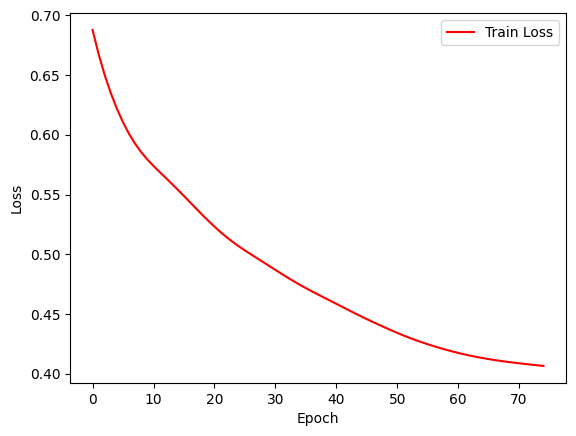

In [247]:
# Plot loss function for training and validation sets
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Train Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train Loss', 'Validation Loss'])

Not bad, but we'd like to see the loss plateau! Have a go at changing some model parameters and see a) if you can get the loss to flatten out, and b) how quickly you can get the model to flatten out. You can adjust things like:
* The number of epochs
* The number of linear layers in the DNN
* The type of activation functions - but the last one should be a sigmoid!
* The learning rate and the optimiser (in particular this might benefit from a larger learning rate)

It shouldn't be hard to find a reasonable model, since our data are pretty easily separable into two classes!

Once you're happy your model has converged, we can go on to defining some metrics to evaluate our model

# Part 4 - Evaluating our model

Our DNN is now trained, which means that the internal parameters (weights and biases) are hopefully set to "optimal" values (where optimality is achieved by gradient descent in the loss space).
We now evaluate the model simply by passing the testing data through it.

In [248]:
# Model evaluation is simple: call the model
# We detach the array
y_pred = model(X_test_scaled).detach()
print(y_pred)

tensor([[0.2134],
        [0.6701],
        [0.0773],
        ...,
        [0.1374],
        [0.3419],
        [0.9543]])


The tensor `y_pred` gives a continuous score, not a binary decision. For a well trained binary classifier, these scores should show good separation, which can be seen through a simple plot

Text(0, 0.5, 'Events')

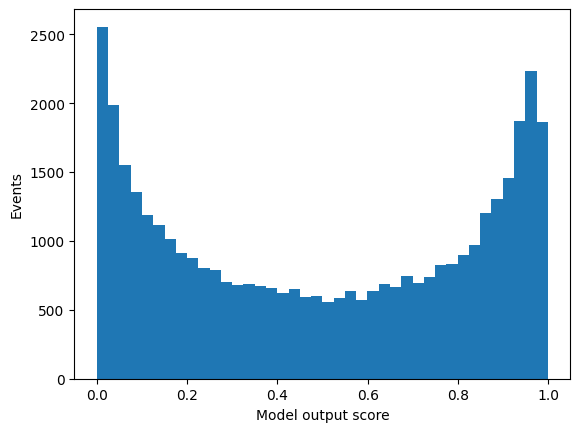

In [249]:
# Plot the scores
plt.hist(y_pred,bins=40)
plt.xlabel('Model output score')
plt.ylabel('Events')

There data exhibit two  peaks  close to 0 and 1, indicating that the DNN can separate the data into two classes reasonably well.

Let's now evaluate whether the model is predicting the classes correctly. This is an arbitrary choice on our part: we must define some threshold value for the model output, above which we consider events to be classed as signal, and below which as background. Based on the above plot, the standard value of 0.5 is appropriate e.g. if the model returns a score >0.5, we shall class this as a signal score, otherwise it's background

In [250]:
threshold = 0.5
y_pred_labels = (y_pred >= threshold).float()

Scikit-learn is useful for providing metrics for evaluating model performance

In [251]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(Y_test, y_pred_labels)
print(accuracy)

0.815025


Text(0, 0.5, 'Events')

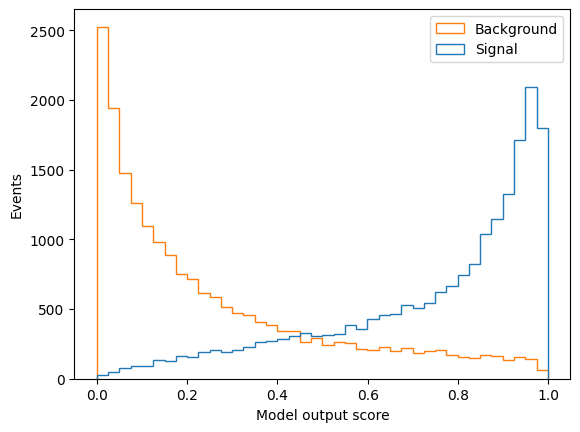

In [252]:
# Plotting the model outputs for signal and background separately
signal_scores = y_pred[Y_test == 1].flatten()
background_scores = y_pred[Y_test == 0].flatten()
plt.hist([signal_scores,background_scores], bins=40, histtype='step', label=['Signal','Background'])
plt.legend()
plt.xlabel('Model output score')
plt.ylabel('Events')

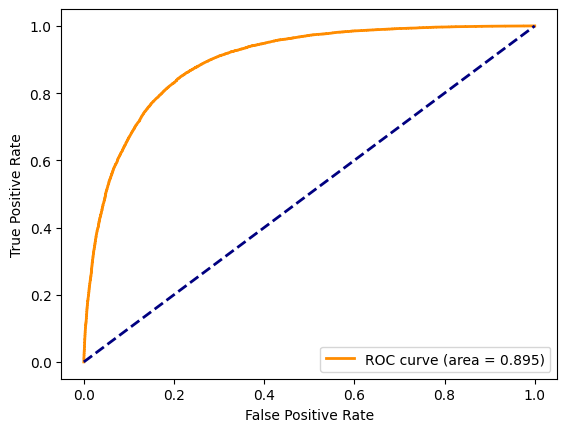

In [253]:
# ROC curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(Y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

Now you know how to build and evaluate you a DNN. Not that hard is it? Perhaps the trickiest part is formulating your data into the correct format.

Now, can you get a model which delivers an AUC over 0.95????

This is the end of the nominal tutorial. What follows are some additional exercises

#  Bonus 1 - More complex data preparation

We have looked at all stages of the ML pipeline in one notebook. It is good practice to split our ML pipeline up into separate Python scripts: one to prepare the data, one to load it into the PyTorch model and train, one to evaluate, and one to study the results. Part of this is then saving our processed data in a format which is suitable for then reading in to PyTorch i.e. saving the data to HDF5 format (industry standard) after applying the selections, and then loading these HDF5 files into torch tensors. The following section shows how to do this...

## Saving to HDF5

We will convert the `signal_array` to a structured numpy array and then use the `h5py` module to save this. `numpy` - as you may already know - is used for array-based programming similarly to `torch`, but more widely used and not optimised for machine learning use-cases (`torch` is designed to be used on the GPU).

Let's look at the simple single lepton example...

In [263]:
import numpy as np

# First we create a unstructured numpy array from the awkward array, by converting each branch to a numpy array and stacking them column-wise

unstructured_numpy_array = np.column_stack([
    final_signal_array['lep_pt'][:,0].to_numpy(),
    final_signal_array['lep_eta'][:,0].to_numpy(),
    final_signal_array['lep_phi'][:,0].to_numpy(),
    final_signal_array['lep_e'][:,0].to_numpy()
])

In [264]:
# Now we define the data type for the structured array
structured_data_type = np.dtype([
    ('lep_pt', np.float32),
    ('lep_eta', np.float32),
    ('lep_phi', np.float32),
    ('lep_e', np.float32)
])

In [265]:
# Finally, we convert the unstructured numpy array to a structured numpy array using built-in numpy functionality
from numpy.lib import recfunctions as rf
structured_numpy_array = rf.unstructured_to_structured(
    unstructured_numpy_array,
    dtype=structured_data_type
)

In [266]:
# Now we can save this as an HDF5 file using h5py
import h5py
with h5py.File('signal_data.h5', 'w') as h5file:
    h5file.create_dataset('signal_dataset', data=structured_numpy_array)

### Re-loading the data for HDF5

In [267]:
# Reading the file
with h5py.File('signal_data.h5', 'r') as h5file:
    loaded_data = h5file['signal_dataset'][:]

In [268]:
# Conver the loaded data to an unstructured numpy array using numpy.lib.recfunctions
loaded_numpy_array = rf.structured_to_unstructured(loaded_data)
# Convert to a torch tensor
input_tensor = torch.tensor(loaded_numpy_array)

In [269]:
input_tensor

tensor([[54.0828,  0.3805,  0.1800, 58.0448],
        [59.0998,  0.9322, -1.5968, 86.6905],
        [47.7161, -0.6910, -0.9606, 59.5694],
        ...,
        [11.8095, -1.2238,  0.5718, 21.8137],
        [33.9109, -0.8821,  2.3215, 47.9804],
        [45.0771, -0.3355,  1.1929, 47.6384]])

## Padding

You may have noticed that our ATLAS OpenData has a "ragged" structure i.e. fields can have different lengths in different events.
For example, the number of jets varies event-to-event.
This is of course a key feature of particle physics data, and a key reason why we use ROOT and the awkward framework.

In general, machine learning frameworks expect non-ragged inputs: our tensors should be rectangular.
We got round this above by looking at events with exactly two leptons and two jets, hence every event had the same amount of features (18 including the two MET variables).

In the more general case, we can **pad** arrays with dummy values. An example is shown below where look at the first four jets in each event, and if an event has less than four events, we "pad" these entries


### Creating padded data

The following cells extract the jet data and pad such that each event has exactl 4 jets. We set the padded jet kinematics to be something unphysical: -99.

In [276]:
# Loading the jet data
jet_array = signal_tree.arrays(["jet_pt","jet_eta","jet_phi","jet_e"])

In [277]:
# Padding the arrays using awkward's pad_none, which pads missing entries with Python's None class
padded_jet_array = ak.pad_none(jet_array,4,clip=True)

In [278]:
# Setting these None values to unphysical float values
padded_jet_array = ak.fill_none(padded_jet_array,-99)

Now we map this object to a structured numpy array, analogously to before. We define a specific dtype, create an array of zeros, and then set the values

In [283]:
# Creating the data_type
import numpy as np
structured_data_type = np.dtype([
    ('jet_pt', np.float32),
    ('jet_eta', np.float32),
    ('jet_phi', np.float32),
    ('jet_e', np.float32)
])

In [284]:
# Creating a placeholder numpy array of zeros. This array is of shape Nevents x 4, but each entry will have a structure based on the structured_data-type
jet_data = np.zeros((len(padded_jet_array),4),dtype=structured_data_type)

In [285]:
jet_data["jet_pt"]   = padded_jet_array["jet_pt"].to_numpy()
jet_data["jet_eta"]  = padded_jet_array["jet_eta"].to_numpy()
jet_data["jet_phi"]  = padded_jet_array["jet_phi"].to_numpy()
jet_data["jet_e"]    = padded_jet_array["jet_e"].to_numpy()


### Reloading the padded data

Re-loading from HDF5 and converting to pytorch

In [ ]:
# Again using numpy inbuilt-in functionality - this should be encouraged
from numpy.lib.recfunctions import structured_to_unstructured

In [ ]:
unstructured_jet_data = structured_to_unstructured(jet_data)

If you were to apply this jet data array to a DNN, you would need to change the shape of the input data. PyTorch operations generally apply to the last dimension of an array. The data is of shape `N_events x N_jets x N_jet_features` - in other words our if we applied a DNN to this, it would only apply to the final jet!

Our DNN needs to operate on an object of shape `N_events x N_DNN_features`. If we have four jets each with four features, this is 16 features.

In [ ]:
Nevents = unstructured_jet_data.shape[0]
reshaped_jet_data = unstructured_jet_data.reshape(Nevents,16)

We can then apply DNN operations on an array of this type e.g.

In [ ]:
from torch import nn, tensor
x = tensor(reshaped_jet_data, dtype=torch.float32)
example_linear_layer = nn.Linear(16,64)
output = example_linear_layer(x)

# Bonus 2 - Other Extensions

The above examples provide a means of taking ATLAS OpenData and converting it into a form for training a DNN. We then built the DNN. Here are some ideas of how to develop this.

### Further DNN Ideas
* Add early stopping to the model, such that the training will terminate early is the loss is not decreasing
* Add a learning rate scheduler, to dynamically adjust the learning rate
* Add regularisation in the form of dropout layers (`nn.Dropout`)
* Split each pass of the data into batches. This becomes important for computationally expensive models, where the operations on the training data become intractable without further splitting of the data into chunks, or "batches".
* Turn the model into a multi-class tagger. Find a third sample, probably a diboson sample i.e. $WW^*$ continuum production.

### Understanding the model
* With our simple DNN example, we can study the importance of each feature by randonly shuffling the values of individual features and seeing the extent to which the model degrades in performance.

### Making it all more PyTorch
PyTorch has extensive functionality; once we understand the basic structure of ML pipelines, we can then build code which better utilises the amazing functionality of pyTorch. Some ideas, in a rough order of increasing complexity:
* Use the `dataset` and `dataloader` to define datasets and automate batching
* Use the `nn.Module` functionality to build your DNN
* Build a custom dataset with `torch.dataset`
* Finally, use PyTorch-Lightning for prototyping models whilst hiding away much boilerplate code!



Here's an example DNN built using `nn.Module`

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleDNN(nn.Module):
    def __init__(self, N_input_features): # You can add more parameters here, such that the size of all layers can be
        # defined in the constructor
        """
        In the constructor we instantiate two nn.Linear modules and two activation functions, assigning them as
        member variables.
        """
        super(SimpleDNN, self).__init__()
        self.linear1 = nn.Linear(N_input_features, 50)
        self.linear2 = nn.Linear(50, 1)
        self.activ1 = nn.ReLU()
        self.activ_final = nn.Sigmoid()

    def forward(self, x):
        """
        Takes as input a tensor x and returns the output tensor after applying the defined layers and activation functions.
        """
        # Compute the forward pass.
        x = self.linear1(x)
        x = self.activ1(x)
        x = self.linear2(x)
        x = self.activ_final(x)
        return x